In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Welcome to Flatland



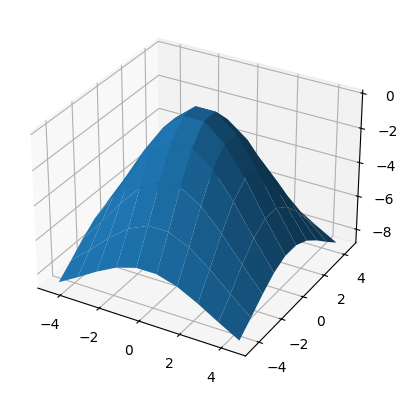

In [2]:
class FlatLand:
    def __init__(self, width, resolution, max_depth, steepness=1):
        self.width = width
        self.resolution = resolution
        self.max_depth = max_depth
        self.steepness = steepness
        
        self.ID = f'FlatLand_{width}_{resolution}'

    def build(self):
        axis = np.arange(-self.width/2, self.width/2, self.resolution)
        axis += self.resolution/2 # middle of the cell
        # all the pairs of coordinates in our world
        x, y = np.meshgrid(axis, axis)
        coordinates = np.dstack([x, y])
        # ensure two standard deviations from 0,0 is the edge of the world
        sd = (self.width/2) / 2 / self.steepness
        distribution = multivariate_normal(mean=[0,0], cov=[[sd,0],[0,sd]])
        # calculate the probability of each point
        z = distribution.pdf(coordinates)
        # turn that into a depth
        scale = self.max_depth / np.max(z) - np.min(z)
        z = (z - np.max(z)) * scale

        self.grid = (x, y, z)
        self.world = (x.flatten(), y.flatten(), z.flatten())

world = FlatLand(
    width=10, 
    resolution=1, 
    max_depth=10, 
    steepness=0.25
)
world.build()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*world.grid);

In [3]:
world_x, world_y, world_z = world.world

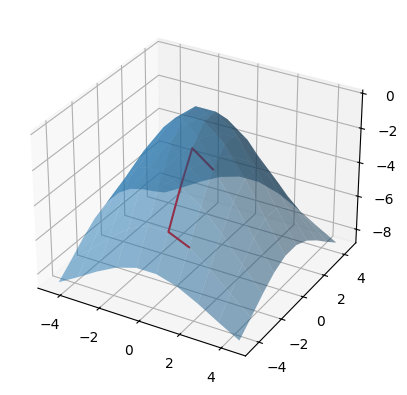

In [183]:
def swim(x, y, speed, steps, world):
    min_x = np.min(world.world[0]) - world.resolution / 2
    # non inclusive max
    max_x = np.max(world.world[0]) + world.resolution / 2 - 10 ** -10
    min_y = np.min(world.world[1]) - world.resolution / 2
    # non inclusive max
    max_y = np.max(world.world[1]) + world.resolution / 2 - 10 ** -10

    x, y = [x], [y]
    sd = speed / 2
    distance_distribution = multivariate_normal(mean=[0], cov=[[sd]])
    for _ in range(steps-1):
        distance = distance_distribution.rvs()
        angle = np.random.uniform(0, 2*np.pi)
        x.append(np.clip(x[-1] + distance * np.cos(angle), min_x, max_x))
        y.append(np.clip(y[-1] + distance * np.sin(angle), min_y, max_y))
    
    resolution = world.resolution
    x = np.array([x // resolution * resolution + resolution / 2 for x in x])
    y = np.array([y // resolution * resolution + resolution / 2 for y in y])
    return x, y

np.random.seed(130)
speed = 1.5
steps = 10
x, y = swim(1.5, -1.5, 1.5, steps, world)
z = np.array([world_z[np.where((world_x == x[i]) & (world_y == y[i]))][0] for i in range(len(x))])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*world.grid, alpha=0.5)
ax.plot(x, y, z, 'r');

# Build the Transfer Matrix

In [184]:
from geolocator.transfer import (
    NormalDistanceDistribution,
    MemoryCache,
    get_transfer_matrix,
)

transfer_distribution = NormalDistanceDistribution(sigma=speed/2)
cache = MemoryCache()
cache_dir = 'cache'
cache.load(cache_dir)

transfer_matrix = get_transfer_matrix(
    transfer_distribution, world, cache, 
    processes=8
)

cache.save(cache_dir)

1.5 -1.5


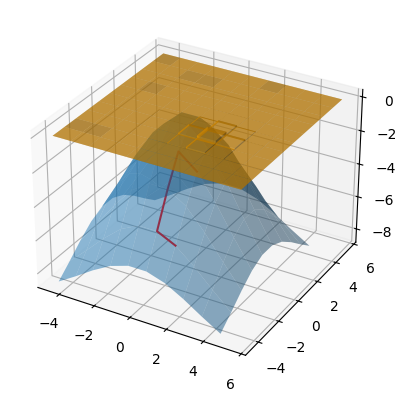

In [185]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*world.grid, alpha=0.5)
ax.plot(x, y, z, 'r');
i = 36
print(world.world[0][i], world.world[1][i])
ax.bar3d(
    world.world[0], world.world[1], 
    np.zeros_like(world.world[0]), 1, 1, 
    transfer_matrix[:, i], alpha=0.5,
    color='orange'
);

# Measurement Likelihood

In [186]:
class NormalMeasurementDistribution:
    def __init__(self, sigma):
        self.sigma = sigma

    def likelihood(self, z, world):
        return np.array([
            multivariate_normal.pdf(
                z, mean=depth, cov=self.sigma
            ) for depth in world.world[2]
        ])

def get_measurement_likelihood(measurement_dist, world, z, min_probability=10**-10):
    likelihood = measurement_dist.likelihood(z, world)
    likelihood[likelihood < min_probability] = 0
    return likelihood

measurement_distribution = NormalMeasurementDistribution(sigma=0.001)
measurement_likelihood = get_measurement_likelihood(
    measurement_distribution, world, z[9]
)

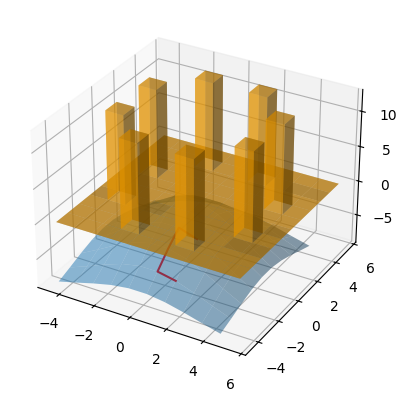

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*world.grid, alpha=0.5)
ax.plot(x, y, z, 'r');
ax.bar3d(
    world.world[0], world.world[1], 
    np.zeros_like(world.world[0]), 1, 1, 
    measurement_likelihood, alpha=0.5,
    color='orange'
);

# Grid Filtering

In [188]:
phi_forward = np.zeros((world.world[0].shape[0], steps))
phi_mid = np.zeros((world.world[0].shape[0], steps))

# initialize the starting position
phi_forward[:, 0][np.where((world.world[0] == x[0]) & (world.world[1] == y[0]))] = 1

# forward filtering
for i in range(1, steps):
    phi_mid[:,i] = np.matmul(transfer_matrix, phi_forward[:, i-1])
    measurement_likelihood = get_measurement_likelihood(
        measurement_distribution, world, z[i]
    )
    joint_likelihoods = measurement_likelihood * phi_mid[:,i]
    phi_forward[:, i] = (
        joint_likelihoods / np.sum(joint_likelihoods)
    )

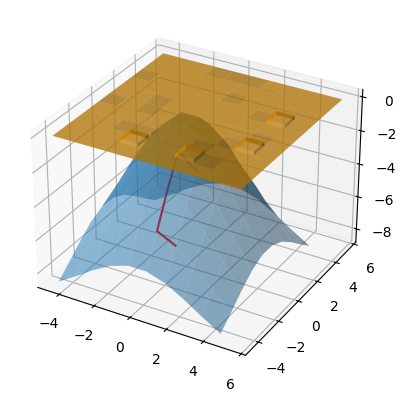

In [189]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*world.grid, alpha=0.5)
ax.plot(x, y, z, 'r');
ax.bar3d(
    world.world[0], world.world[1], 
    np.zeros_like(world.world[0]), 1, 1, 
    phi_forward[:, 9], alpha=0.5,
    color='orange'
);

# Smoothing

In [190]:
phi_backward = np.zeros((world.world[0].shape[0], steps))

# initialize the starting position
phi_backward[:, -1][np.where((world.world[0] == x[-1]) & (world.world[1] == y[-1]))] = 1

for i in range(steps-2, -1, -1):
    ratio = phi_backward[:, i+1] / phi_mid[:, i+1]
    ratio = np.nan_to_num(ratio, nan=0)
    mid = np.matmul(transfer_matrix.T, ratio)
    #mid = np.nan_to_num(mid, nan=0)
    phi_backward[:, i] = mid * phi_forward[:, i]

/tmp/ipykernel_98343/193885881.py:7: RuntimeWarning: invalid value encountered in divide
  ratio = phi_backward[:, i+1] / phi_mid[:, i+1]


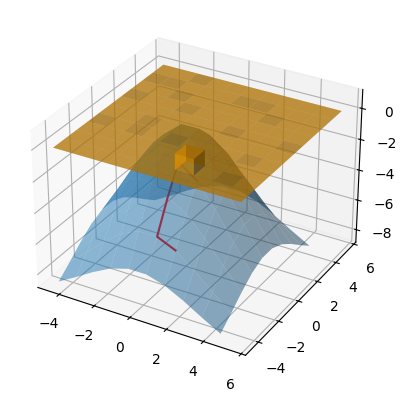

In [191]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*world.grid, alpha=0.5)
ax.plot(x, y, z, 'r');
ax.bar3d(
    world.world[0], world.world[1], 
    np.zeros_like(world.world[0]), 1, 1, 
    phi_backward[:, 9], alpha=0.5,
    color='orange'
);

# Retrieve Most Likely Pathway

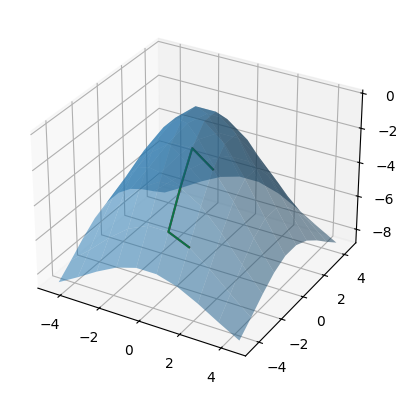

In [192]:
x_pred = np.array([world.world[0][i] for i in phi_backward.argmax(axis=0)])
y_pred = np.array([world.world[1][i] for i in phi_backward.argmax(axis=0)])
z_pred = np.array([world.world[2][i] for i in phi_backward.argmax(axis=0)])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*world.grid, alpha=0.5)
ax.plot(x, y, z, 'r');
ax.plot(x_pred, y_pred, z_pred, 'g');